In [1]:
import pandas as pd
import calendar
import matplotlib.pyplot as plt
import numpy as np
from shapely.geometry import shape
from shapely.ops import unary_union
import osmnx as ox
import json
from pathlib import Path

loading Data

In [ ]:
# df_nat_crz = pd.read_csv("NYC_NTA_with_CBD_flag.csv")
# df = pd.read_parquet("mta_ridership_by_nta_2021_2025_with_cbd_flags.parquet", engine="pyarrow")

Filting Data to be 5-10, weekday, August, 2024,2025 and label each observation's origin and destination with is_cbd(is_crz)

In [ ]:
# df = df.drop(columns = ['origin_is_cbd'])
# df = df.drop(columns = ['destination_is_cbd'])
# df = df.drop(columns = ['origin_nta_name'])
# df = df.drop(columns = ['destination_nta_name'])
# df = df.merge(
#     df_nat_crz[['NTA2020', 'is_cbd']],
#     how='left',
#     left_on='origin_nta',
#     right_on='NTA2020'
# )
# df = df.drop(columns=['NTA2020'])
# df = df.rename(columns={'is_cbd': 'is_origin_crz'})
# df = df.merge(
#     df_nat_crz[['NTA2020', 'is_cbd']],
#     how='left',
#     left_on='destination_nta',
#     right_on='NTA2020'
# )
# df = df.drop(columns=['NTA2020'])
# df = df.rename(columns={'is_cbd': 'is_destination_crz'})
# df_rush_weekday = df[df['ts'].dt.weekday.between(0, 4) & df['ts'].dt.hour.between(5, 10) & df['ts'].dt.year.between(2024, 2025) & df['ts'].dt.month.between(8,8)]

In [ ]:
# df_rush_weekday.to_csv("rush_weekday.csv", index=False)

In [5]:
df_rush_weekday = pd.read_csv("rush_weekday.csv")

Divide the data into 4 categroies

In [6]:
origin_crz      = df_rush_weekday["is_origin_crz"]
destination_crz = df_rush_weekday["is_destination_crz"]
noncrz_to_noncrz_rush_weekday = df_rush_weekday[(~origin_crz) & (~destination_crz)]
crz_to_noncrz_rush_weekday    = df_rush_weekday[( origin_crz) & (~destination_crz)]
noncrz_to_crz_rush_weekday    = df_rush_weekday[(~origin_crz) & ( destination_crz)]
crz_to_crz_rush_weekday       = df_rush_weekday[( origin_crz) & ( destination_crz)]

In [7]:
noncrz_to_noncrz_rush_weekday.to_csv(
    "noncrz_to_noncrz_rush_weekday.csv", index=False
)
crz_to_noncrz_rush_weekday.to_csv(
    "crz_to_noncrz_rush_weekday.csv", index=False
)
noncrz_to_crz_rush_weekday.to_csv(
    "noncrz_to_crz_rush_weekday.csv", index=False
)
crz_to_crz_rush_weekday.to_csv(
    "crz_to_crz_rush_weekday.csv", index=False
)

Add weekday counts for each row in a August.

In [8]:
def add_weekday_count_in_month(df, ts_col='ts', new_col='weekday_count_in_month'):
    ts = pd.to_datetime(df[ts_col])
    years   = ts.dt.year
    months  = ts.dt.month
    weekdays = ts.dt.weekday      
    combos = pd.DataFrame({
        'year': years,
        'month': months,
        'weekday': weekdays,
    }).drop_duplicates()
    counts = {}
    for _, row in combos.iterrows():
        y, m, w = int(row['year']), int(row['month']), int(row['weekday'])
        month_cal = calendar.monthcalendar(y, m)  
        cnt = sum(1 for week in month_cal if week[w] != 0)
        counts[(y, m, w)] = cnt
    df[new_col] = [
        counts[(y, m, w)]
        for y, m, w in zip(years, months, weekdays)
    ]
    return df

In [9]:
noncrz_to_noncrz_rush_weekday = add_weekday_count_in_month(noncrz_to_noncrz_rush_weekday, ts_col='ts',
                                new_col='weekday_count_in_month')
crz_to_noncrz_rush_weekday = add_weekday_count_in_month(crz_to_noncrz_rush_weekday, ts_col='ts',
                                new_col='weekday_count_in_month')
noncrz_to_crz_rush_weekday = add_weekday_count_in_month(noncrz_to_crz_rush_weekday, ts_col='ts',
                                new_col='weekday_count_in_month')
crz_to_crz_rush_weekday = add_weekday_count_in_month(crz_to_crz_rush_weekday, ts_col='ts',
                                new_col='weekday_count_in_month')
noncrz_to_noncrz_rush_weekday['EAR_MONTH'] = noncrz_to_noncrz_rush_weekday['weekday_count_in_month'] * noncrz_to_noncrz_rush_weekday['Estimated Average Ridership']
crz_to_noncrz_rush_weekday['EAR_MONTH'] = crz_to_noncrz_rush_weekday['weekday_count_in_month'] * crz_to_noncrz_rush_weekday['Estimated Average Ridership']
noncrz_to_crz_rush_weekday['EAR_MONTH'] = noncrz_to_crz_rush_weekday['weekday_count_in_month'] * noncrz_to_crz_rush_weekday['Estimated Average Ridership']
crz_to_crz_rush_weekday['EAR_MONTH'] = crz_to_crz_rush_weekday['weekday_count_in_month'] * crz_to_crz_rush_weekday['Estimated Average Ridership']

C:\Users\luyang_han\AppData\Local\Temp\ipykernel_23828\752297808.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[new_col] = [
C:\Users\luyang_han\AppData\Local\Temp\ipykernel_23828\752297808.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[new_col] = [
C:\Users\luyang_han\AppData\Local\Temp\ipykernel_23828\752297808.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the 

Compute final results

In [11]:
dfs = {
    "nn": noncrz_to_noncrz_rush_weekday,
    "cn": crz_to_noncrz_rush_weekday,
    "nc": noncrz_to_crz_rush_weekday,
    "cc": crz_to_crz_rush_weekday,
}
totals = {}
for k, df in dfs.items():
    df["ts"] = pd.to_datetime(df["ts"])
    totals[f"total_counts_{k}"] = df["EAR_MONTH"].sum()
    for year in [2024, 2025]:
        mask = df["ts"].dt.year == year
        totals[f"total_counts_{k}_{year}"] = df.loc[mask, "EAR_MONTH"].sum()


C:\Users\luyang_han\AppData\Local\Temp\ipykernel_23828\2589778477.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["ts"] = pd.to_datetime(df["ts"])
C:\Users\luyang_han\AppData\Local\Temp\ipykernel_23828\2589778477.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["ts"] = pd.to_datetime(df["ts"])
C:\Users\luyang_han\AppData\Local\Temp\ipykernel_23828\2589778477.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] 

In [12]:
total_counts_nn       = totals["total_counts_nn"]
total_counts_nn_2024  = totals["total_counts_nn_2024"]
total_counts_nn_2025  = totals["total_counts_nn_2025"]

total_counts_cn       = totals["total_counts_cn"]
total_counts_cn_2024  = totals["total_counts_cn_2024"]
total_counts_cn_2025  = totals["total_counts_cn_2025"]

total_counts_nc       = totals["total_counts_nc"]
total_counts_nc_2024  = totals["total_counts_nc_2024"]
total_counts_nc_2025  = totals["total_counts_nc_2025"]

total_counts_cc       = totals["total_counts_cc"]
total_counts_cc_2024  = totals["total_counts_cc_2024"]
total_counts_cc_2025  = totals["total_counts_cc_2025"]



In [13]:
flows = ["nn", "cn", "nc", "cc"]
rows = []
for k in flows:
    rows.append({
        "Flow type": k.upper(),
        "Total":     totals[f"total_counts_{k}"],
        "2024":      totals[f"total_counts_{k}_2024"],
        "2025":      totals[f"total_counts_{k}_2025"],
    })
summary_table = pd.DataFrame(rows).set_index("Flow type")
print("Monthly total counts")
print(summary_table)

Monthly total counts
                  Total          2024          2025
Flow type                                          
NN         1.739144e+07  8.606271e+06  8.785174e+06
CN         4.701057e+06  2.380888e+06  2.320169e+06
NC         1.742356e+07  8.734066e+06  8.689497e+06
CC         6.798606e+06  3.437829e+06  3.360777e+06


In [14]:
d2024 = pd.date_range("2024-08-01", "2024-08-31", freq="D")
n_weekdays_2024_08 = (d2024.weekday < 5).sum()
d2025 = pd.date_range("2025-08-01", "2025-08-31", freq="D")
n_weekdays_2025_08 = (d2025.weekday < 5).sum()
print(n_weekdays_2024_08)  
print(n_weekdays_2025_08)  

22
21


In [15]:
total_counts_nn_daily       = total_counts_nn/(n_weekdays_2024_08 + n_weekdays_2025_08)
total_counts_nn_2024_daily  = total_counts_nn_2024/n_weekdays_2024_08
total_counts_nn_2025_daily  = total_counts_nn_2025/n_weekdays_2025_08

total_counts_cn_daily       = total_counts_cn/(n_weekdays_2024_08 + n_weekdays_2025_08)
total_counts_cn_2024_daily  = total_counts_cn_2024/n_weekdays_2024_08
total_counts_cn_2025_daily  = total_counts_cn_2025/n_weekdays_2025_08

total_counts_nc_daily       = total_counts_nc/(n_weekdays_2024_08 + n_weekdays_2025_08)
total_counts_nc_2024_daily  = total_counts_nc_2024/n_weekdays_2024_08
total_counts_nc_2025_daily  = total_counts_nc_2025/n_weekdays_2025_08

total_counts_cc_daily       = total_counts_cc/(n_weekdays_2024_08 + n_weekdays_2025_08)
total_counts_cc_2024_daily  = total_counts_cc_2024/n_weekdays_2024_08
total_counts_cc_2025_daily  = total_counts_cc_2025/n_weekdays_2025_08

Daily results

In [16]:
df_daily = pd.DataFrame(
    [
        ["NN", total_counts_nn_daily, total_counts_nn_2024_daily, total_counts_nn_2025_daily],
        ["CN", total_counts_cn_daily, total_counts_cn_2024_daily, total_counts_cn_2025_daily],
        ["NC", total_counts_nc_daily, total_counts_nc_2024_daily, total_counts_nc_2025_daily],
        ["CC", total_counts_cc_daily, total_counts_cc_2024_daily, total_counts_cc_2025_daily],
    ],
    columns=[
        "Flow type",
        "Avg 2024+2025 (per weekday)",
        "Avg 2024 (per weekday)",
        "Avg 2025 (per weekday)",
    ],
).set_index("Flow type")

print(df_daily)

           Avg 2024+2025 (per weekday)  Avg 2024 (per weekday)  \
Flow type                                                        
NN                       404452.194744           391194.121464   
CN                       109326.909172           108222.193509   
NC                       405199.133972           397002.992645   
CC                       158107.116312           156264.949682   

           Avg 2025 (per weekday)  
Flow type                          
NN                  418341.604848  
CN                  110484.230343  
NC                  413785.567743  
CC                  160037.005162  


Visulization

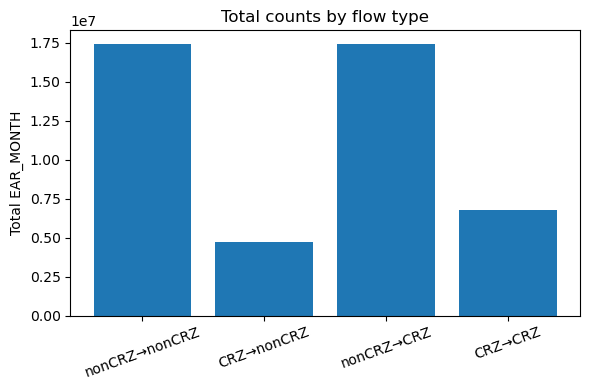

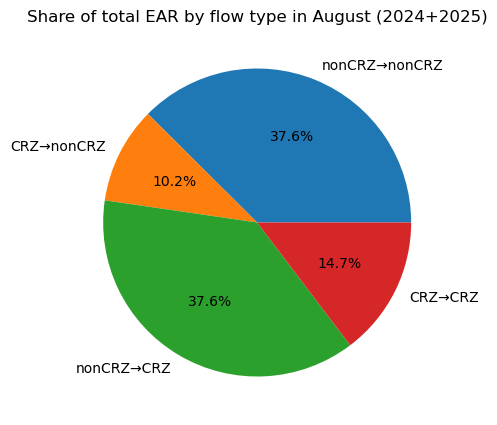

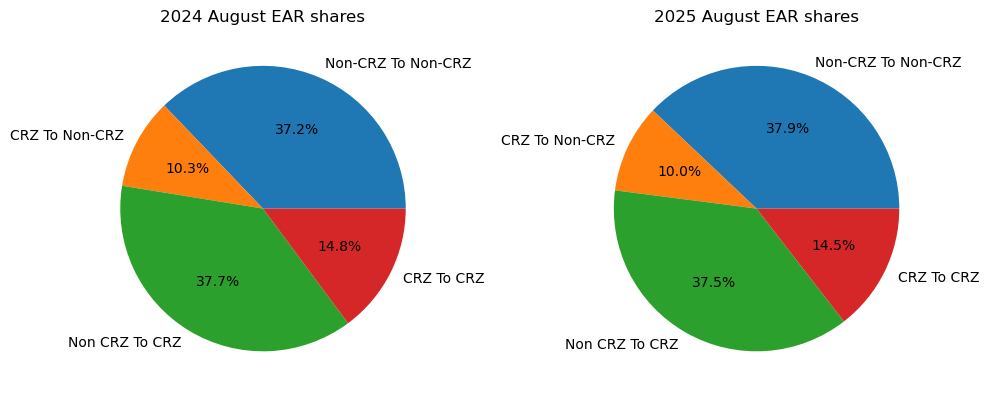

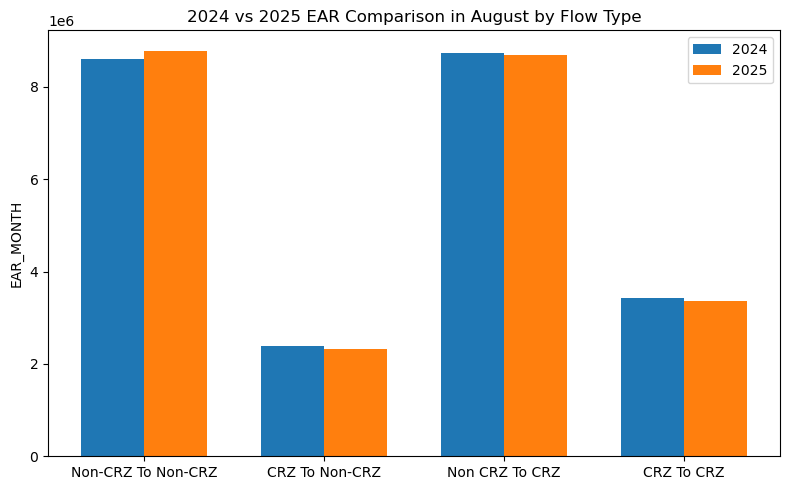

In [17]:
values = [
    total_counts_nn,
    total_counts_cn,
    total_counts_nc,
    total_counts_cc
]
labels = ["nonCRZ→nonCRZ", "CRZ→nonCRZ", "nonCRZ→CRZ", "CRZ→CRZ"]

plt.figure(figsize=(6, 4))
plt.bar(labels, values)
plt.ylabel("Total EAR_MONTH")
plt.title("Total counts by flow type")
plt.xticks(rotation=20)
plt.tight_layout()
plt.show()

plt.figure(figsize=(5, 5))
plt.pie(values, labels=labels, autopct="%.1f%%")
plt.title("Share of total EAR by flow type in August (2024+2025)")
plt.show()

labels = ['Non-CRZ To Non-CRZ', 'CRZ To Non-CRZ', 'Non CRZ To CRZ', 'CRZ To CRZ']

sizes_2024 = [
    total_counts_nn_2024,
    total_counts_cn_2024,
    total_counts_nc_2024,
    total_counts_cc_2024
]

sizes_2025 = [
    total_counts_nn_2025,
    total_counts_cn_2025,
    total_counts_nc_2025,
    total_counts_cc_2025
]

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].pie(sizes_2024, labels=labels, autopct='%1.1f%%')
axes[0].set_title('2024 August EAR shares')

axes[1].pie(sizes_2025, labels=labels, autopct='%1.1f%%')
axes[1].set_title('2025 August EAR shares')

plt.tight_layout()
plt.show()


labels = ['Non-CRZ To Non-CRZ', 'CRZ To Non-CRZ', 'Non CRZ To CRZ', 'CRZ To CRZ']
v2024 = [total_counts_nn_2024, total_counts_cn_2024, total_counts_nc_2024, total_counts_cc_2024]
v2025 = [total_counts_nn_2025, total_counts_cn_2025, total_counts_nc_2025, total_counts_cc_2025]

x = np.arange(len(labels))
width = 0.35

plt.figure(figsize=(8, 5))
plt.bar(x - width/2, v2024, width, label='2024')
plt.bar(x + width/2, v2025, width, label='2025')

plt.xticks(x, labels)
plt.ylabel("EAR_MONTH")
plt.title("2024 vs 2025 EAR Comparison in August by Flow Type")
plt.legend()
plt.tight_layout()
plt.show()